In [1]:
import rustworkx as rx
from rustworkx.visualization import mpl_draw
import numpy as np
import scipy as sp
from numpy.random import rand
import matplotlib.pyplot as plt
import time

from math import prod

In [2]:
dense_grids = {}

def grid_graph(dim):
    r"""
    Generate a dense graph of dimension len(dim) with side lengths
    define by the tuple `dim`
    
    This graphs are not labeled with spatial coordinates
    """
    if len(dim) == 1:
        return rx.generators.path_graph(dim[0])
    elif len(dim) == 2:
        return rx.generators.path_graph(dim[0],dim[1])
    else:
        G=rx.generators.path_graph(dim[0])
        for idx in range(1,len(dim)):
            Gnew=rx.generators.path_graph(dim[idx])
            G, _ = rx.cartesian_product(Gnew,G)
        return G
    

def generate_percolation_graph(p,dim):
    r"""
    generate a percolation graph with bond acceptance probability p
    `dim` should be a tuple containing the dimension of the graph,
    e.g (L,) or (L,L)
    """
    if dim in dense_grids:
        G = dense_grids[dim].copy()
    else:
        G = grid_graph(dim)
        dense_grids[dim] = G.copy()
    
    temp = [edge if p < rand() else -1 for edge in G.edge_list()]
    remove_list = [x for x in temp if x != -1] if -1 in temp else temp
    G.remove_edges_from(remove_list)
    return G

def avg_cluster_size(p, dim, repititions=100):
    r"""
    For a square graph of L*L nodes, compute the average cluster size,
    excluding the largest cluster. As L->infinity, this ensures that this
    function diverges at the phase transition, but nowhere else.
    """
    sites=prod(dim)
    counts = np.zeros(sites+1,dtype=np.int64)
    for _ in range(repititions):
        G = generate_percolation_graph(p,dim)
        comps = rx.connected_components(G)
        distro = [len(comp) for comp in comps]
        largest_local = np.max(distro)
        temp_counts = np.bincount([len(comp) for comp in comps],minlength=sites+1)
        temp_counts[largest_local]=0
        counts += temp_counts
    bins = np.array(range(sites+1))    
    return (bins**2 @ counts) / (bins@counts)

def percolation_strength(p,dim,repititions=100):
    r"""
    For a square graph of L*L nodes, compute the percolation strength,
    which is the proportion of the graph belonging to the largest cluster,
    which should be the order paramater of the phase tranistion as L->infinity
    """
    P = 0
    sites = prod(dim)
    for _ in range(repititions):
        G = generate_percolation_graph(p,dim)
        distro = [len(comp) for comp in rx.connected_components(G)]
        largest_local = np.max(distro)
        P += largest_local / sites
    return P/repititions

def cluster_size_and_strength(p,dim,repititions=100):
    r"""
    return both the percolation strength and the average cluster size
    for the square L*L percolation graph as a tuple (size, strength)
    """
    sites = prod(dim)
    counts = np.zeros(sites+1,dtype=np.int64)
    P = 0
    for _ in range(repititions):
        G = generate_percolation_graph(p,L)
        distro = [len(comp) for comp in rx.connected_components(G)]
        largest_local = np.max(distro)
        P += largest_local / sites
        temp_counts = np.bincount([len(comp) for comp in rx.connected_components(G)],minlength=sites+1)
        temp_counts[largest_local]=0
        counts += temp_counts
    bins = np.array(range(sites+1))    
    return (bins**2 @ counts) / (bins@counts), P

In [8]:
pvals = np.arange(.15,.35,.01)

reps=100
density = {}
strength = {}
Lvals = [50,60,70,80,90,100]
dims = [(L,L,L) for L in Lvals]

for dim in dims:
    start = time.time()
    density[dim] = [avg_cluster_size(p,dim,repititions=reps) for p in pvals]
    strength[dim] = [percolation_strength(p,dim,repititions=reps) for p in pvals]
    end = time.time()
    print(f"Avg Computation time per graph for L={dim[0]} is {(end-start)/(reps*len(pvals))} s")

Avg Computation time per graph for L=50 is 0.5269523253440856 s
Avg Computation time per graph for L=60 is 0.9145952743291855 s
Avg Computation time per graph for L=70 is 1.458669538974762 s
Avg Computation time per graph for L=80 is 2.1927363061904908 s
Avg Computation time per graph for L=90 is 3.150589908480644 s
Avg Computation time per graph for L=100 is 4.341495970129967 s


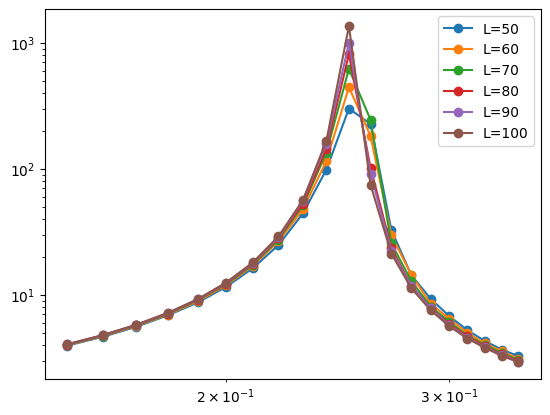

In [9]:
for dim in dims:
    plt.loglog(pvals,density[dim],label=f"L={dim[0]}",marker='o')
plt.legend()
plt.show()

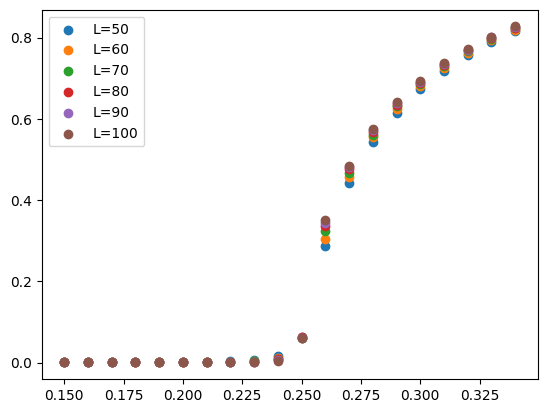

In [11]:
for dim in dims:
    plt.scatter(pvals,strength[dim],label=f"L={dim[0]}")
plt.legend()
plt.show()

In [3]:
def grid_graph_2d(L):
    r"""
    Returns a 2d square lattice where each noce is labeled by a spatial
    location, stored as a tuple of integers, (a,b)
    """
    G = rx.PyGraph()
    G.add_nodes_from([(i,j) for j in range(L) for i in range(L)])
    G.add_edges_from([(i+j*L,i+1+j*L,None) for j in range(L) for i in range(L-1)])
    G.add_edges_from([(i+j*L,i+(j+1)*L,None) for j in range(L-1) for i in range(L)])
    return G

In [77]:
def grid_graph_3d(L):
    r"""
    Returns a 2d square lattice where each noce is labeled by a spatial
    location, stored as a tuple of integers, (a,b)
    """
    G = rx.PyGraph()
    G.add_nodes_from([(i,j,k) for k in range(L) for j in range(L) for i in range(L)])
    G.add_edges_from([(i+j*L+k*L**2,(i+1)+j*L+k*L**2,None) for k in range(L) for j in range(L) for i in range(L-1)])
    G.add_edges_from([(i+j*L+k*L**2,(i)+(j+1)*L+k*L**2,None) for k in range(L) for j in range(L-1) for i in range(L)])
    G.add_edges_from([(i+j*L+k*L**2,(i)+j*L+(k+1)*L**2,None) for k in range(L-1) for j in range(L) for i in range(L)])
    return G

In [104]:
def grid_graph(L,dim=2):
    G=rx.generators.path_graph(L)
    Gnew=rx.generators.path_graph(L)
    for _ in range(dim-1):
        G, hold = rx.cartesian_product(Gnew,G)
    return G

In [14]:
lst = [[0, 0, 0], [3, 0, 0], [3, 2, 0]]
for val1,val2 in zip(lst[0:-1],lst[1:]):
    print(f"{val1},{val2}")

[0, 0, 0],[3, 0, 0]
[3, 0, 0],[3, 2, 0]


In [4]:
G=grid_graph_2d(7)

In [5]:
 # Now we cut edges!
p = 0.55
marked_edges_idxs = [edge for edge in G.edge_indices() if p < rand()]
marked_edges = [G.edge_list()[idx] for idx in marked_edges_idxs]

In [6]:
G.remove_edges_from(marked_edges)
comps = rx.connected_components(G)

In [7]:
distro = [len(comp) for comp in comps]
largest_local = np.max(distro)
ll_idx = np.argmax(distro)

In [19]:
largest_subgraph = list(comps[ll_idx])
largest_sg_locs = [G.nodes()[idx] for idx in largest_subgraph]

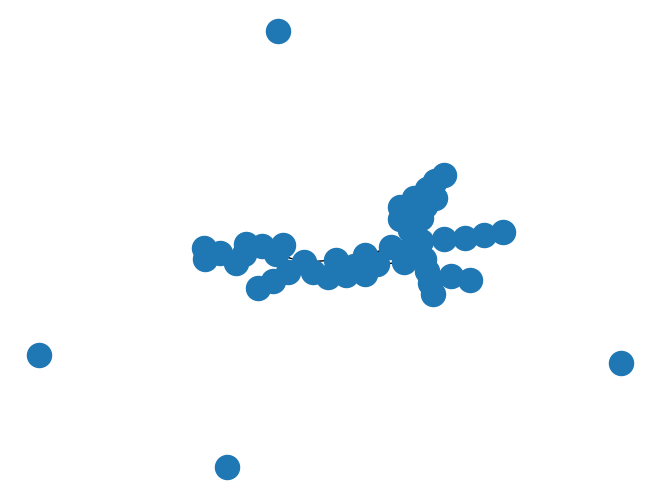

In [20]:
mpl_draw(G)

In [ ]:
v1=largest_subgraph[round(rand()*largest_local)]
v2=largest_subgraph[round(rand()*largest_local)]

In [22]:
rx.all_shortest_paths(G,v1,v2)

[[28, 21, 22, 15, 16, 17, 10, 11, 12, 13, 6, 5],
 [28, 29, 22, 15, 16, 17, 10, 11, 12, 13, 6, 5],
 [28, 21, 22, 15, 16, 17, 18, 19, 12, 13, 6, 5],
 [28, 29, 22, 15, 16, 17, 18, 19, 12, 13, 6, 5],
 [28, 21, 22, 15, 16, 17, 18, 19, 20, 13, 6, 5],
 [28, 29, 22, 15, 16, 17, 18, 19, 20, 13, 6, 5]]

In [29]:
print(rx.dijkstra_shortest_paths(G,v1,v2))

PathMapping{5: [28, 29, 22, 15, 16, 17, 10, 11, 12, 13, 6, 5]}


In [24]:
v2

5

In [25]:
largest_local

np.int64(45)

In [30]:
G[v1]

(0, 4)

In [32]:
G[v2]

(5, 0)

In [33]:
G[v2]+(0,)

(5, 0, 0)

In [35]:
G[v1]

(0, 4)

In [36]:
G.nodes()[v1]

(0, 4)

In [45]:
G.node_indexes()[3]

3

In [48]:
len(G.neighbors(2))

0